In [883]:
import numpy as np
from importlib import reload
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse as mplEllipse
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint, solve_ivp, solve_bvp
import matplotlib.animation as animation

## expansion of parafine wax with temeperature

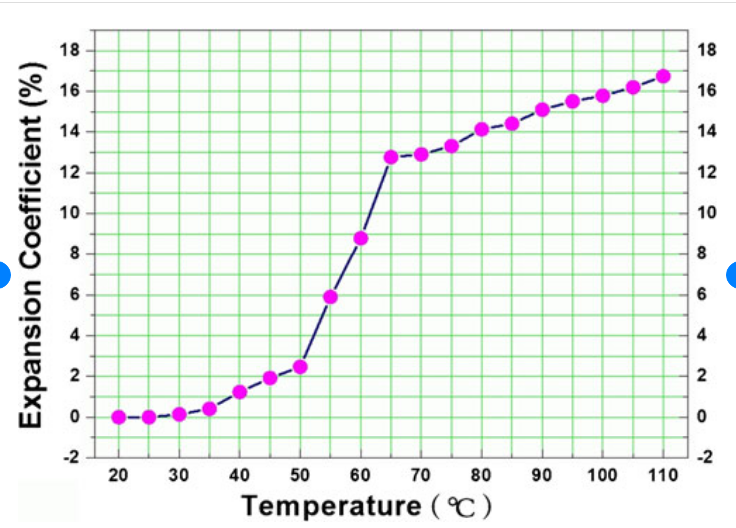

The specific wax used in lava lamp melts at around 45 degrees celsius. They add some oil in it. So we approximate this material by a using only the linear behaviour at arbitary temperature

In [5]:
T0=20
k=-1
e_T=0.001
rho0=1.05
V0=1
g=10
rho_w=1

Text(0, 0.5, 'expansion')

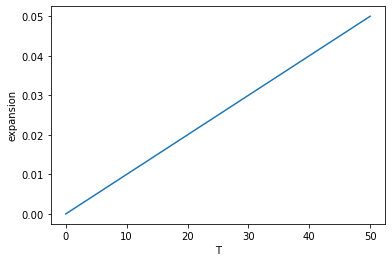

In [6]:
def e(T): return e_T*T#=0.13
TT=np.linspace(0,50)
plt.plot(TT,e(TT))
plt.xlabel('T');plt.ylabel('expansion')

## calculate density
parafine wax has density of 0.9, but with the oil inside is just a bit more than the water, so right now let's say 1.05

Text(0, 0.5, 'density')

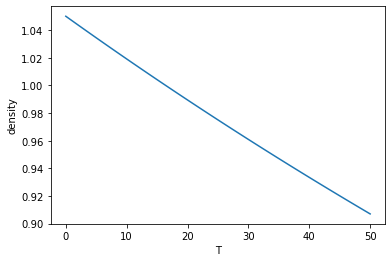

In [7]:
def rho(T,rho0): return rho0/(1+e(T))**3
plt.plot(TT,rho(TT,rho0))
plt.xlabel('T');plt.ylabel('density')

## thermal distribution inside the lamp
lets say for now a square root behaviour, need to solve the transfer equation

$$ \frac{\partial u}{\partial t} = a\nabla^2u $$
and due to cylidrical symmetry, we employ cylindrical coordinates $\rho,\theta,z$. If we further suppose that the heat transfer in all other axes different than z is negligible, we have $u(\rho,\theta,z,t) = u(z,t) $. 
$$ \frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial^2 z} $$
Next, we suppose that $u(z,t) = T(t)U(z)$ and thsi results:
$$ \frac{dT}{dt}T^{-1} = a\frac{d^2 U}{d^2 z} U^{-1}$$ so
$$Τ = Τ_0e^{c_1 t} $$ where $c_1$ is an integration constant.

Text(0, 0.5, 'T')

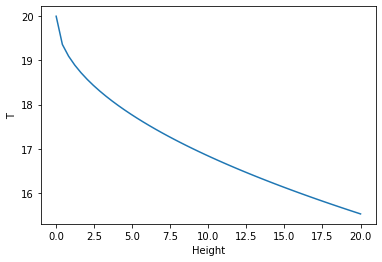

In [153]:
def Trod(y,T0,k): return T0+k*y**(0.5)
k=-1
yy=np.linspace(0,20)
plt.plot(yy,Trod(yy,T0,k))
plt.xlabel('Height');plt.ylabel('T')

Text(0, 0.5, 'T')

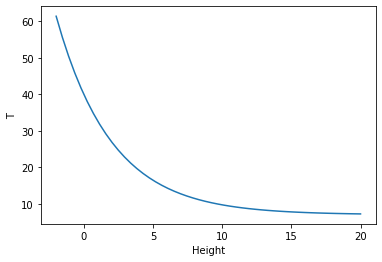

In [450]:

def Trod(y,T0,k): 
    T1=7
    return (T0-T1)*np.exp(k*y)+T1
yy=np.linspace(-2,20)
T0=40
k=-0.25
plt.plot(yy,Trod(yy,T0,k))
plt.xlabel('Height');plt.ylabel('T')

$$ \frac{\partial u}{\partial t} = a\nabla^2u $$
and due to cylidrical symmetry, we employ cylindrical coordinates $\rho,\theta,z$. If we further suppose that the heat transfer in all other axes different than z is negligible, we have $u(\rho,\theta,z,t) = u(z,t) $. 
$$ \frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial^2 z} $$
Next, we suppose that $u(z,t) = T(t)U(z)$ and thsi results:
$$ \frac{dT}{dt}T^{-1} = a\frac{d^2 U}{d^2 z} U^{-1}$$ so
$$Τ = Τ_0e^{c_1 t} $$ where $c_1$ is an integration constant.
For the spatial part, we suppose a solution of the form:
$$U(z) \sim e^{izc_2} $$
Thus, $$U(z) = c_A e^{izc_2} + c_B e^{-izc_2}$$
Requiring that the phenomenon remains unchangeable over time, we got $c_1 = 0$. 
$$ u(0,t) = T_0$$ so
$$ c_A + c_B = 1$$
Employing the boundary condition $u(h,t) = T_h $, we got
$$ u(h,t) = T_0 (ic_Asin(hc_2) + cos(hc_2))$$
Also, we need to have real solutions, so $c_A = 0$
From the requirement $u(h,t) = T_h$ we obtain $c_2 = 1/hcos^{-1}(T_h/T_0)$
Putting all together,
$$ u(z,t) = T_0cos\left(\frac{z}{h} cos^{-1}(T_h/T_0)\right)$$

Text(0, 0.5, 'T')

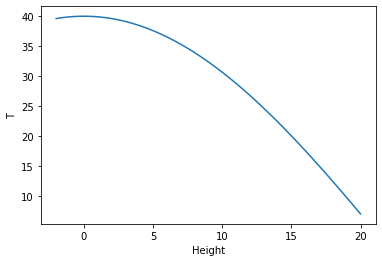

In [474]:
def Trod(y,T0,k): 
    T1=7
    h=20
    c=np.arccos(T1/T0)/h
    return T0*np.cos(y*c)
yy=np.linspace(-2,20)
T0=40
k=-0.25
plt.plot(yy,Trod(yy,T0,k))
plt.xlabel('Height');plt.ylabel('T')

Text(0, 0.5, 'density')

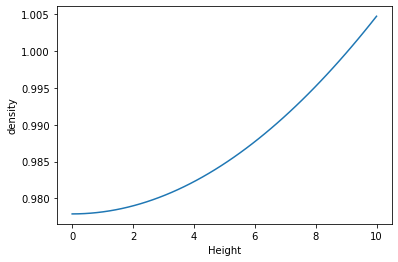

In [475]:
yy=np.linspace(0,10)
plt.plot(yy,rho(Trod(yy,T0,k),rho0))
plt.xlabel('Height');plt.ylabel('density')

In [814]:
rho_w=1
T0=40
T1=10
y_h=10
maxy=y_h
rho0=1.075
g=9
u=7

def Trod(y,T0,T1,y_h): 
    c=np.arccos(T1/T0)/y_h
    return T0*np.cos(y*c)

def dY_dt(t,Y,rho_w,T0,T1,y_h,rho0,g,u): 
    y,v,T=Y
    dy=v
    dv=(rho_w/rho(T,rho0)-1)*g 
    dT=-(1/u)*(T-Trod(y,T0,T1,y_h)) #newton cooling
    return [dy,dv,dT]


def hit_top(t, y,rho_w,T0,T1,y_h,rho0,g,u): return y[0]-maxy
hit_top.terminal=True
def hit_ground(t,y,rho_w,T0,T1,y_h,rho0,g,u): return y[0]
hit_ground.terminal=True

tp=50
dt=0.1
tt=np.arange(0,tp,dt)
Y0=[0,0,40]
A=solve_ivp(dY_dt,(tt[0],tt[-1]),Y0,t_eval=tt,args=(rho_w,T0,T1,y_h,rho0,g,u),events=[hit_top])
sols=[A]
print(A.message,A.t_events,A.y_events)
for k in range(20):
    Y0=[sols[-1].y[0][-1],np.random.normal(0,1e-2),sols[-1].y[2][-1]]
    tt=np.arange(sols[-1].t[-1],sols[-1].t[-1]+tp,dt)
    B=solve_ivp(dY_dt,(tt[0],tt[-1]),Y0,t_eval=tt,args=(rho_w,T0,T1,y_h,rho0,g,u),events=[hit_top,hit_ground])
    sols.append(B)
    #print(k,B.message,B.t_events,B.y_events)

A termination event occurred. [array([6.98700311])] [array([[10.        ,  2.72865299, 34.43389816]])]


In [815]:
def plot_sols(sols):
    fig,ax=plt.subplots(1,4,figsize=(30,7))
    for sol in sols:
        ax[0].plot(sol.t,sol.y[0]); ax[0].set(ylabel='Height')
        ax[1].plot(sol.t,sol.y[1]); ax[1].set(ylabel='Velocity')
        ax[2].plot(sol.t,sol.y[2]); ax[2].set(ylabel='Bubble temperature')
        ax[3].plot(sol.t,rho(sol.y[2],rho0)); ax[3].set(ylabel='Bubble density')
        #ax[4].plot(sol.t,V(sol.y[0],T0,k,rho0,V0)); ax[4].set(ylabel='Bubble volume')
    for axi in ax: 
        axi.set(xlabel='time') 
        #axi.axvline(45)

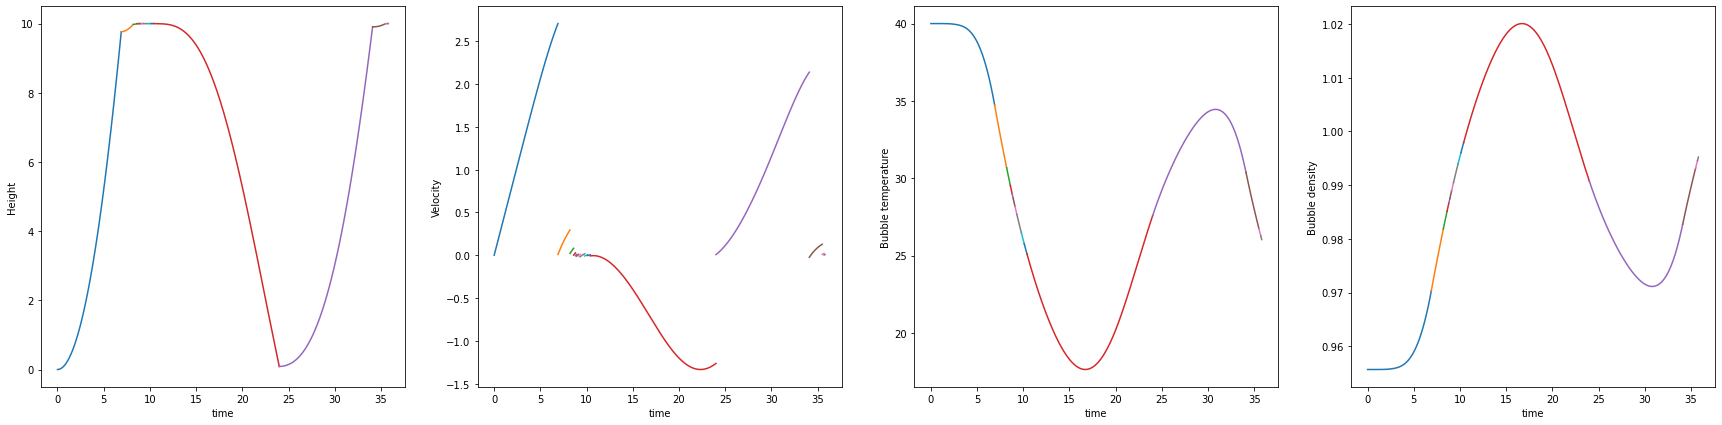

In [816]:
plot_sols(sols)

In [817]:
tt=np.array([])
yy=np.array([])
rr=np.array([])
for sol in sols:
    tt=np.append(tt,sol.t)
    yy=np.append(yy,sol.y[0])
    rr=np.append(rr,(V(sol.y[0],T0,k,rho0,V0)/(4*np.pi/3))**(1/3))

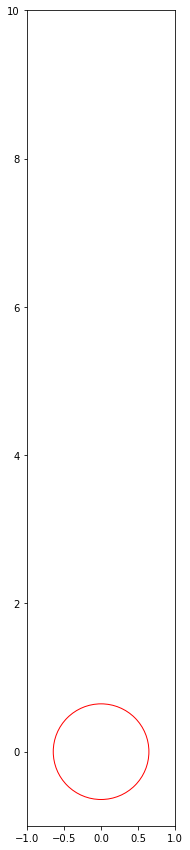

In [880]:
fig = plt.figure(figsize=(5,15))
plt.axis([-1,1,-1,11])
ax = plt.gca()
ax.set_aspect(1)
ax.set(xlim=[-1,1],ylim=[-1,10])
i=0
t=tt[::ii][i]
y=yy[::ii][i]
r=rr[::ii][i]
circle1 = plt.Circle((0, y),r, color='r',fill=False)#, clip_on=False)
    
def init():
    ax.add_artist(circle1)
    return circle1,
ii=1
def animate(i):
    # draw circles, select to color for the circles based on the input argument i. 
    #someColors = ['r', 'b', 'g', 'm', 'y']
    patches = []
    #for t,y,r in zip(tt[::ii],yy[::ii],rr[::ii]):
    t=tt[::ii][i]
    y=yy[::ii][i]
    r=rr[::ii][i]
    circle1.set_center((0,y))
    circle1.set_radius(r)
    return circle1,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=378, interval=70, blit=True)

In [853]:
from IPython.display import HTML

In [881]:
anim.save('test.gif')

In [882]:
HTML(anim.to_html5_video())